# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Process/Issues
- Double-checked that the images we were given were correctly bounded (did this by visualizing the boxes on the images - they look good!)
- Complication: Originally when I creating augmented images, the bounding box labels did not also augment. I also had to try out a few types of augmentation to see what made sense for waldo. The augmented images may still not be as different from one another as they could be which could allow the model to favor the training images that occur more frequently.
- Complication: Similarly, when resizing the images, ensuring the bounding boxes not only are also adjusted if necessary, but ensuring they do not get cut off and the image is not stretched/shrunk too much.
- Tried Yolo architecture first but produced too many boxes and did not work well. Tried faster rcnn architecture next and the inputs and outputs and processing steps for each were very different which was frustrating

### Imports

In [1]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("mps")
print(device)

mps


### Download Data

In [3]:
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-4-wheres-waldo/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading 2024-fall-ml-3-hw-4-wheres-waldo.zip to ./2024-fall-ml-3-hw-4-wheres-waldo


100%|██████████| 38.2M/38.2M [00:01<00:00, 36.8MB/s]



Extracting archive ./2024-fall-ml-3-hw-4-wheres-waldo/2024-fall-ml-3-hw-4-wheres-waldo.zip to ./2024-fall-ml-3-hw-4-wheres-waldo


### Paths

In [4]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File

# Preprocessing

### Check size of each training imaage

In [5]:
# Train Images
import cv2

# Iterate over all images in the folder
for image_name in os.listdir(train_folder):
    if image_name.endswith((".jpg")):  # Check for common image extensions
        image_path = os.path.join(train_folder, image_name)
        
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is not None:
            height, width, channels = img.shape  # Get image size (height, width, channels)
            print(f"Image: {image_name}, Width: {width}, Height: {height}")
        else:
            print(f"Could not read image: {image_name}")

#Image 27 includes waldo 6 times, 10 2 times, 8 2 times
#16,22-27 do not include waldo in a background

Image: 8.jpg, Width: 2800, Height: 1760
Image: 9.jpg, Width: 1298, Height: 951
Image: 14.jpg, Width: 1700, Height: 2340
Image: 15.jpg, Width: 1600, Height: 1006
Image: 17.jpg, Width: 1599, Height: 1230
Image: 16.jpg, Width: 1525, Height: 3415
Image: 12.jpg, Width: 1276, Height: 1754
Image: 13.jpg, Width: 1280, Height: 864
Image: 11.jpg, Width: 2828, Height: 1828
Image: 10.jpg, Width: 1600, Height: 980
Image: 21.jpg, Width: 2048, Height: 1515
Image: 20.jpg, Width: 2953, Height: 2088
Image: 22.jpg, Width: 500, Height: 256
Image: 23.jpg, Width: 325, Height: 300
Image: 27.jpg, Width: 591, Height: 629
Image: 26.jpg, Width: 600, Height: 374
Image: 18.jpg, Width: 1590, Height: 981
Image: 24.jpg, Width: 456, Height: 256
Image: 25.jpg, Width: 413, Height: 500
Image: 19.jpg, Width: 1280, Height: 864
Image: 4.jpg, Width: 2048, Height: 1272
Image: 5.jpg, Width: 2100, Height: 1760
Image: 7.jpg, Width: 1949, Height: 1419
Image: 6.jpg, Width: 2048, Height: 1454
Image: 2.jpg, Width: 1286, Height: 946


### Draw bounding boxes on each training image to check accuracy

In [6]:
# Paths
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/checks"  # Folder to save images with drawn boxes

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file
# Assumes the CSV columns are: filename, xmin, ymin, xmax, ymax
annotations = pd.read_csv(annotations_file)

# Iterate through each image in the annotations
for _, row in annotations.iterrows():
    image_name = row["filename"]
    x_min, y_min, x_max, y_max = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    
    # Load the image
    image_path = os.path.join(train_folder, image_name)
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue
    image = cv2.imread(image_path)
    
    # Draw the bounding box
    # cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (B, G, R), thickness)
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 4)
    
    # Optionally, add a label or text
    label = "Waldo"
    cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Save the image
    output_path = os.path.join(output_folder, image_name)
    cv2.imwrite(output_path, image)

    print(f"Annotated image saved to {output_path}")

print("All bounding boxes have been drawn and saved.")

Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/1.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/10.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/11.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/12.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/13.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/14.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/15.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/17.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/18.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/19.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/2.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/3.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/4.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/5.j

### Create More Training Images

In [7]:
#Capture each waldo bounding box and save to waldo folder to create set of waldos

# Define the paths
image_folder = train_folder
csv_path = annotations_file
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/waldo"


# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file
with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)  # Use DictReader for column names
    counter = 1

    for row in csv_reader:
        # Extract information from the CSV
        filename = row["filename"]
        x_min = int(row["xmin"])
        y_min = int(row["ymin"])
        x_max = int(row["xmax"])
        y_max = int(row["ymax"])

        base, ext = os.path.splitext(filename)  # Split filename into base and extension
        counter += 1

        # Construct the full path to the image
        image_path = os.path.join(image_folder, filename)

        # Check if the image exists
        if os.path.exists(image_path):
            with Image.open(image_path) as img:
                # Crop the image using bounding box coordinates
                cropped_img = img.crop((x_min, y_min, x_max, y_max))

                # Save the cropped image
                if os.path.exists(os.path.join(output_folder, f"cropped_{filename}")):
                    filename = f"{base}_{counter}{ext}"  # Add suffix to filename
                    #counter += 1
                    output_path = os.path.join(output_folder, f"cropped_{filename}")
                    cropped_img.save(output_path)
                else:
                    output_path = os.path.join(output_folder, f"cropped_{filename}")
                    cropped_img.save(output_path)
        else:
            print(f"Warning: {filename} not found in {image_folder}")

### Remove background from waldo images
#!pip3 install onnxruntime
from rembg import remove
import io

##### Define the paths
input_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/waldo"  # Folder containing the .jpg images
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/waldo_clean"  # Folder where you want to save the processed images

##### Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

##### Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith('.jpg'):  # Only process .jpg files
        image_path = os.path.join(input_folder, filename)

        # Open the image and remove the background
        with open(image_path, 'rb') as input_file:
            input_data = input_file.read()
            output_data = remove(input_data)  # Remove background

            # Save the resulting image as PNG (to preserve transparency)
            output_path = os.path.join(output_folder, f"no_background_{filename[:-4]}.jpg")
            with open(output_path, 'wb') as output_file:
                output_file.write(output_data)

            print(f"Background removed and saved: {output_path}")


In [8]:
#Exclude no-busy-background images as they don't appear in the test set (16, 22-27)

def delete_files_from_list(folder_path, file_names_to_delete):
    """Deletes files in the given folder if their name is in the provided list."""

    for filename in os.listdir(folder_path):
        if filename in file_names_to_delete:
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

if __name__ == "__main__":
    folder_path = train_folder
    file_names_to_delete = ["16.jpg", "22.jpg", "23.jpg", "24.jpg", "25.jpg", "26.jpg", "27.jpg"]  # Replace with your file names
    delete_files_from_list(folder_path, file_names_to_delete)

Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/16.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/22.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/23.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/27.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/26.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/24.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/25.jpg


In [9]:
# Define the paths
input_folder = train_folder
overlay_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/waldo"
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/chunks"
csv_path = "2024-fall-ml-3-hw-4-wheres-waldo/train/annotations_chunks.csv"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open the CSV file for saving bounding box annotations
with open(csv_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write header
    csv_writer.writerow(["filename", "x_min", "y_min", "x_max", "y_max"])

    # Parameters
    chunk_size = 128

    # Get the list of image files
    large_images = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.jpg')]
    smaller_images = [os.path.join(overlay_folder, f) for f in os.listdir(overlay_folder) if f.endswith('.jpg')]

    # Process each large image
    for img_idx, large_image_path in enumerate(large_images):
        with Image.open(large_image_path) as img:
            img = img.convert("RGBA")  # Ensure RGBA mode for transparency
            width, height = img.size

            # Chop into 128x128 chunks
            for top in range(0, height, chunk_size):
                for left in range(0, width, chunk_size):
                    box = (left, top, left + chunk_size, top + chunk_size)
                    chunk = img.crop(box)

                    # If the chunk is smaller than 128x128, pad it
                    if chunk.size != (chunk_size, chunk_size):
                        padded_chunk = Image.new("RGBA", (chunk_size, chunk_size), (255, 255, 255, 0))
                        padded_chunk.paste(chunk, (0, 0))
                        chunk = padded_chunk

                    # Randomly select a smaller image
                    overlay_path = random.choice(smaller_images)
                    try:
                        with Image.open(overlay_path) as overlay:
                            overlay = overlay.convert("RGBA")  # Ensure RGBA mode

                            # Resize overlay to fit within the chunk
                            max_overlay_size = (random.randint(32, chunk_size), random.randint(32, chunk_size))
                            overlay.thumbnail(max_overlay_size, Image.Resampling.LANCZOS)

                            # Random position for overlay
                            overlay_x = random.randint(0, chunk_size - overlay.width)
                            overlay_y = random.randint(0, chunk_size - overlay.height)

                            # Superimpose the overlay onto the chunk
                            chunk.paste(overlay, (overlay_x, overlay_y), overlay)

                            # Calculate bounding box
                            x_min = overlay_x
                            y_min = overlay_y
                            x_max = overlay_x + overlay.width
                            y_max = overlay_y + overlay.height

                            # Save bounding box to CSV
                            output_filename = f"chunk_{img_idx}_{top}_{left}.jpg"
                            csv_writer.writerow([output_filename, x_min, y_min, x_max, y_max])

                            # Save the resulting 128x128 image
                            output_path = os.path.join(output_folder, output_filename)
                            chunk.convert("RGB").save(output_path, "JPEG")

                    except Exception as e:
                        print(f"Error processing overlay {overlay_path}: {e}")


# Train/Test Split

In [11]:
# Split training data into train and validation sets
annotations = pd.read_csv("2024-fall-ml-3-hw-4-wheres-waldo/train/annotations_chunks.csv")
image_files = annotations["filename"].unique()
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

def filter_csv_by_column(input_csv, output_csv, column_name, values_list):

    # Load the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Filter the DataFrame
    filtered_df = df[df[column_name].isin(values_list)]

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

#Train Annotations
values_list = list(train_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter
filter_csv_by_column("2024-fall-ml-3-hw-4-wheres-waldo/train/annotations_chunks.csv", output_csv, column_name, values_list)

#Test Annotations
values_list = list(val_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter
filter_csv_by_column("2024-fall-ml-3-hw-4-wheres-waldo/train/annotations_chunks.csv", output_csv, column_name, values_list)

#Train/Test Split (80/20)
def split_directory(source_dir, target_dir, file_list):
    """Splits files from source_dir to target_dir based on file_list."""

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, file_name)

        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    source_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/chunks"
    target_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/val"
    file_list = list(val_images)

    split_directory(source_dir, target_dir, file_list)

Moved: chunk_1_128_768.jpg
Moved: chunk_11_640_768.jpg
Moved: chunk_13_1152_896.jpg
Moved: chunk_10_512_2432.jpg
Moved: chunk_0_1664_1664.jpg
Moved: chunk_9_640_256.jpg
Moved: chunk_13_256_1664.jpg
Moved: chunk_18_1152_1664.jpg
Moved: chunk_0_768_896.jpg
Moved: chunk_8_0_640.jpg
Moved: chunk_2_1536_0.jpg
Moved: chunk_13_640_256.jpg
Moved: chunk_16_768_256.jpg
Moved: chunk_14_256_1408.jpg
Moved: chunk_10_0_2816.jpg
Moved: chunk_15_640_384.jpg
Moved: chunk_8_256_1408.jpg
Moved: chunk_5_1536_1152.jpg
Moved: chunk_3_896_256.jpg
Moved: chunk_5_0_128.jpg
Moved: chunk_12_384_0.jpg
Moved: chunk_16_1408_384.jpg
Moved: chunk_7_640_2048.jpg
Moved: chunk_13_1024_512.jpg
Moved: chunk_10_1024_2304.jpg
Moved: chunk_2_896_128.jpg
Moved: chunk_3_128_512.jpg
Moved: chunk_7_128_768.jpg
Moved: chunk_13_640_1152.jpg
Moved: chunk_19_256_640.jpg
Moved: chunk_1_512_768.jpg
Moved: chunk_0_384_512.jpg
Moved: chunk_6_768_1152.jpg
Moved: chunk_2_1792_256.jpg
Moved: chunk_7_640_128.jpg
Moved: chunk_4_512_0.jpg
Mov

In [25]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        #torchvision.transforms.Resize((128, 128)), #does this resize the bounding box too?
        torchvision.transforms.ToTensor()
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        #torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))  # Fix the collate_fn to return a list of images and targets
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))  # Same here for validation
)


# Model

### Architecture

In [18]:
# Define the model
class SimpleBBoxModel(nn.Module):
    def __init__(self):
        super(SimpleBBoxModel, self).__init__()
        # Define a simple CNN architecture
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define a fully connected layer to output 4 values for the bounding box
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Flattening 64 channels of 16x16 feature maps
        self.fc2 = nn.Linear(128, 4)  # Outputting the 4 bounding box coordinates

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Pooling to reduce the spatial dimensions
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Pooling again
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # Final pooling
        
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        bbox = self.fc2(x)  # Output 4 values for the bounding box
        
        return bbox

# Example usage:
model = SimpleBBoxModel()

# Input a batch of 128x128 RGB images (batch_size=2)
images = torch.randn(2, 3, 128, 128)  # Random images for demonstration

# Forward pass
output = model(images)
print("Bounding box predictions: ", output)


Bounding box predictions:  tensor([[-0.0922, -0.0034,  0.1063,  0.0513],
        [-0.0936, -0.0086,  0.1050,  0.0552]], grad_fn=<AddmmBackward0>)


### Training

In [27]:
# Set up the model, loss, and optimizer
model = SimpleBBoxModel()#.to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_data_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_data_loader:
            #images = images.to(device)
            #targets = targets.to(device)
            # Unzip the targets
            target_boxes = [target["boxes"] for target in targets]  # Extract bounding boxes
            
            # Convert the list of bounding boxes to a tensor
            target_boxes = torch.stack(target_boxes)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_data_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation loop
def evaluate(model, val_data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in val_data_loader:
            #images = images.to(device)
            #targets = targets.to(device)
            target_boxes = [target["boxes"] for target in targets]
            target_boxes = torch.stack(target_boxes)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_data_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")


# Train the model
train(model, train_data_loader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, val_data_loader, criterion)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([12, 1, 4])) that is different to the input size (torch.Size([12, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 26.8783
Epoch 2/20, Loss: 24.6763
Epoch 3/20, Loss: 24.5753
Epoch 4/20, Loss: 24.5310
Epoch 5/20, Loss: 24.5815
Epoch 6/20, Loss: 24.4667
Epoch 7/20, Loss: 24.5807
Epoch 8/20, Loss: 24.4157
Epoch 9/20, Loss: 24.2784
Epoch 10/20, Loss: 24.3668
Epoch 11/20, Loss: 24.2110
Epoch 12/20, Loss: 24.2515
Epoch 13/20, Loss: 24.2661
Epoch 14/20, Loss: 24.3190
Epoch 15/20, Loss: 24.2173
Epoch 16/20, Loss: 24.2556
Epoch 17/20, Loss: 24.2121
Epoch 18/20, Loss: 24.2178
Epoch 19/20, Loss: 24.1646
Epoch 20/20, Loss: 24.2345
Evaluation Loss: 24.2192


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([3, 1, 4])) that is different to the input size (torch.Size([3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


# Submission File 

Predicted Bounding Box: [47.064144 37.169506 84.28592  81.09324 ]


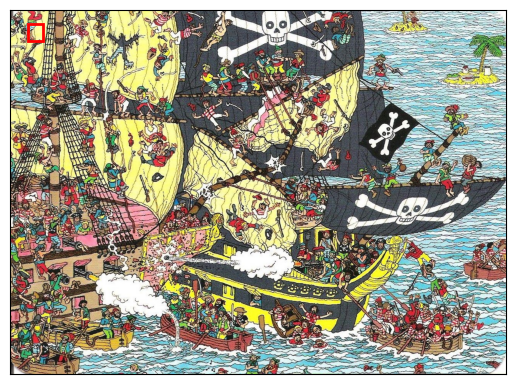

Predicted Bounding Box: [47.053574 37.17307  84.27932  81.09713 ]


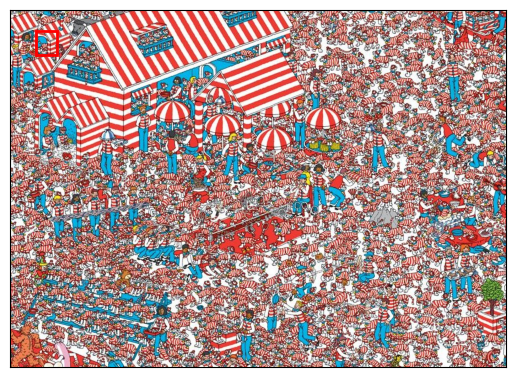

Predicted Bounding Box: [47.057076 37.160175 84.260765 81.07242 ]


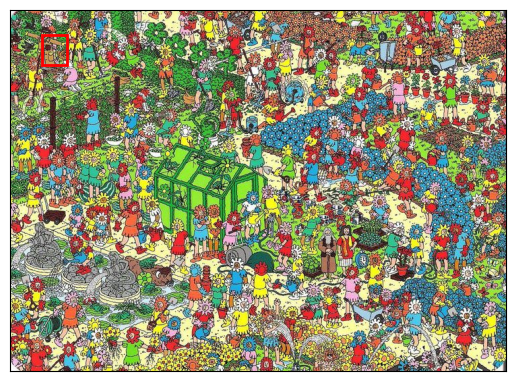

Predicted Bounding Box: [46.966454 37.09332  84.10727  80.92431 ]


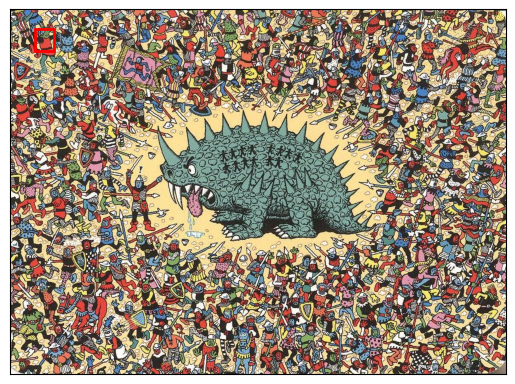

Predicted Bounding Box: [46.898354 37.037605 83.99389  80.814064]


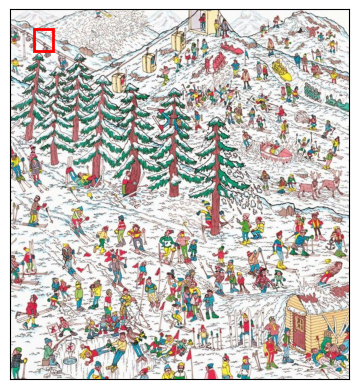

Predicted Bounding Box: [47.074448 37.17158  84.302284 81.1155  ]


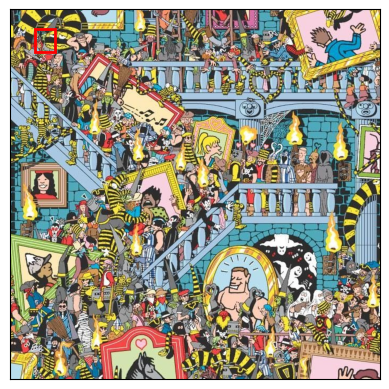

Predicted Bounding Box: [46.873863 37.02032  83.93491  80.75305 ]


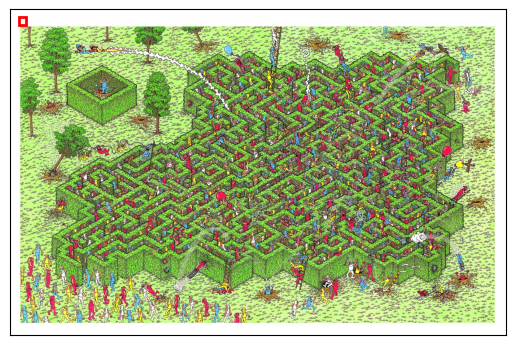

Predicted Bounding Box: [47.114525 37.211433 84.38004  81.18419 ]


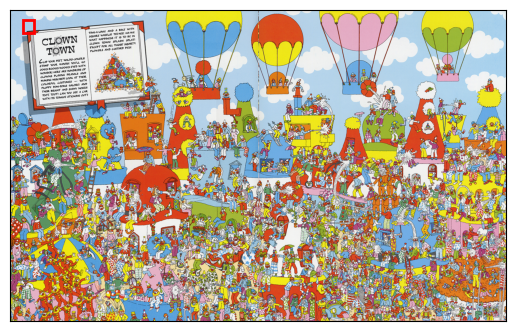

Predicted Bounding Box: [47.115364 37.21533  84.38473  81.19512 ]


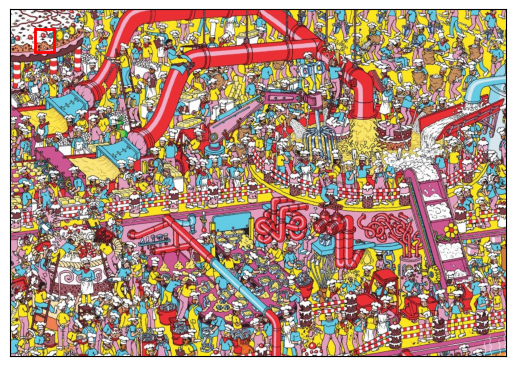

In [28]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    if transform:
        image = transform(image)  # Apply transformations like resizing, normalization
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, 128, 128)

    # Predict the bounding box
    with torch.no_grad():  # No need to calculate gradients during prediction
        predicted_bbox = model(image)  # Get predicted bounding box

    return predicted_bbox.squeeze().cpu().numpy()  # Remove batch dimension and return as numpy array

# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor()  # Convert the image to a tensor
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    # Example usage for prediction on a new image
    image_path = os.path.join(test_folder, name)  # Replace with the path to your test image
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
